In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers

class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):
    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(
                    self.inputs_, self.outputs_, return_dict=True
                )["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_title("The Loss Surface")
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            )
        )
        # Create Contour Plot
        CS = ax.contour(
            xs,
            ys,
            zs,
            levels=levels,
            cmap="magma",
            linewidths=0.75,
            norm=mpl.colors.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
        )
        ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
        return ax


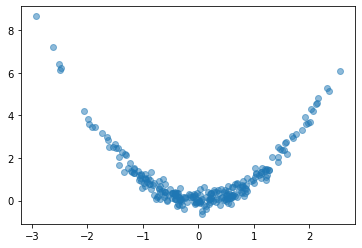

In [2]:
# Create some data
NUM_EXAMPLES = 256
BATCH_SIZE = 64
x = tf.random.normal(shape=(NUM_EXAMPLES, 1))
err = tf.random.normal(shape=x.shape, stddev=0.25)
y = x ** 2 + err
y = tf.squeeze(y)
ds = (tf.data.Dataset
      .from_tensor_slices((x, y))
      .shuffle(NUM_EXAMPLES)
      .batch(BATCH_SIZE))
plt.plot(x, y, 'o', alpha=0.5);


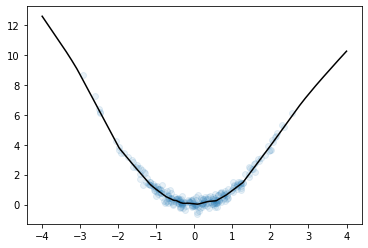

In [3]:
# Fit a fully-connected network (ie, a multi-layer perceptron)
model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])
model.compile(
  loss='mse',
  optimizer='adam',
)
history = model.fit(
  ds,
  epochs=200,
  verbose=0,
)

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')


In [4]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=coords)

# Look at loss surface
plt.figure(dpi=100)
loss_surface.plot()


TypeError: ignored

In [ ]:
from sklearn.decomposition import PCA

# Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec


def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix


def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list


def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list


class PCACoordinates(object):
    def __init__(self, training_path):
        origin = training_path[-1]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)


In [ ]:
# Create data
ds = (
    tf.data.Dataset.from_tensor_slices((inputs, outputs))
    .repeat()
    .shuffle(1000, seed=SEED)
    .batch(BATCH_SIZE)
)
# Define Model
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=[1]),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),      
        layers.Dense(1),
    ]
)

model.compile(
    optimizer="adam", loss="mse",
)

training_path = [model.get_weights()]
# Callback to collect weights as the model trains
collect_weights = callbacks.LambdaCallback(
    on_epoch_end=(
        lambda batch, logs: training_path.append(model.get_weights())
    )
)

history = model.fit(
    ds,
    steps_per_epoch=1,
    epochs=40,
    callbacks=[collect_weights],
    verbose=0,
)

In [ ]:
# Create loss surface
coords = PCACoordinates(training_path)
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=coords, range=0.2)
# Look at loss surface
loss_surface.plot(dpi=150)


In [ ]:
def weights_to_coordinates(coords, training_path):
    """Project the training path onto the first two principal components
using the pseudoinverse."""
    components = [coords.v0_, coords.v1_]
    comp_matrix = vectorize_weight_list_(components)
    # the pseudoinverse
    comp_matrix_i = np.linalg.pinv(comp_matrix)
    # the origin vector
    w_c = vectorize_weights_(training_path[-1])
    # center the weights on the training path and project onto components
    coord_path = np.array(
        [
            comp_matrix_i @ (vectorize_weights_(weights) - w_c)
            for weights in training_path
        ]
    )
    return coord_path


def plot_training_path(coords, training_path, ax=None, end=None, **kwargs):
    path = weights_to_coordinates(coords, training_path)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    colors = range(path.shape[0])
    end = path.shape[0] if end is None else end
    norm = plt.Normalize(0, end)
    ax.scatter(
        path[:, 0], path[:, 1], s=4, c=colors, cmap="cividis", norm=norm,
    )
    return ax

In [ ]:
pcoords = PCACoordinates(training_path)
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=pcoords, range=0.4)
ax = loss_surface.plot(dpi=150)
plot_training_path(pcoords, training_path, ax)
